# Análisis proyecciones y tamaños de bodega

1. Demandas acumuladas para asignación de bodegas
2. Análisis de tamaño de bodegas óptimas
3. Medidas de desempeño 
4. Demandas para simulación

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## 1. Demandas acumuladas para asignación de bodegas óptima

Juntamos Asignaciones de cada caso con las demandas por bodega, para determinar cuanta demanda es asignada a cada una de las bodegas que se abren. Luego, realizamos esto mismo para la proyección.

In [26]:
# Bases de datos

# Ventas categorizadas y asignación resultante
bdd_ventas = pd.read_excel("BDD_Bodegas_Categorizada.xlsx")
bdd_asignaciones = pd.read_excel("Resultados/tiempos_p_3_Manhattan.xlsx")
bdd_ventas['Fecha'] = pd.to_datetime(bdd_ventas['Fecha'])
bdd_ventas['Año'] = bdd_ventas['Fecha'].dt.year

# Proyecciones categorizadas y asignación resultante
bdd_proyecciones = pd.read_excel("BDD_Bodegas_Categorizada_proy.xlsx")
bdd_asignaciones_proy = pd.read_excel("Resultados/tiempos_p_3_Manhattan_proy.xlsx")

#Comunas
bdd_comunas = pd.read_excel("BDD_Bodegas.xlsx", sheet_name=3)


In [27]:
# Agrupación de ventas por cliente 
bdd_ventas_agrupadas = bdd_ventas.groupby(['ID Cliente', 'Año']).agg({"Cantidad": "sum", "Comuna Despacho": "first", 'ID Bodega Despacho': 'first', 'Categoria': 'first'}).reset_index()
bdd_ventas_agrupadas = bdd_ventas_agrupadas.merge(bdd_comunas, left_on='Comuna Despacho', right_on='Comuna')
bdd_ventas_agrupadas['Cantidad'] = bdd_ventas_agrupadas['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)

# Agrupación de proyecciones por cliente
bdd_proyecciones_agrupadas = bdd_proyecciones.groupby("ID Cliente").agg({"Cantidad": "sum", "Comuna Despacho": "first", 'ID Bodega Despacho': 'first', 'Categoria': 'first'}).reset_index()
bdd_proyecciones_agrupadas = bdd_proyecciones_agrupadas.merge(bdd_comunas, left_on='Comuna Despacho', right_on='Comuna')
bdd_proyecciones_agrupadas['Cantidad'] = bdd_proyecciones_agrupadas['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)

In [28]:

# Juntamos asginaciones con demandas tanto de la bdd historica como de la proyeccion
bdd_historica = bdd_ventas_agrupadas.merge(bdd_asignaciones, left_on = "ID Cliente", right_on = "Unnamed: 0" )
bdd_proyecciones = bdd_proyecciones_agrupadas.merge(bdd_asignaciones_proy, left_on = "ID Cliente", right_on = "Unnamed: 0" )

In [29]:
# Resultados
resultado_1 = bdd_historica.groupby(['Bodega Asignada', 'Año'])['Cantidad'].sum().reset_index()
resultado_2 = bdd_proyecciones.groupby('Bodega Asignada')['Cantidad'].sum().reset_index()

In [32]:
# Resultado demandas historicas
resultado_1

,Bodega Asignada,Año,Cantidad
0,1,2017,7.052968e+04
1,1,2018,1.117268e+05
2,1,2019,1.201880e+05
3,1,2020,1.541155e+05
4,1,2021,2.952299e+05
5,1,2022,1.571276e+05
6,4,2017,1.658810e+05
7,4,2018,2.428851e+05
8,4,2019,3.156269e+05
9,4,2020,3.546894e+05


In [60]:
# Resultados promedio de demandas históricas

#Agrupamos todos los años y sacamos promedio anual
resultado_1b = resultado_1.groupby('Bodega Asignada')['Cantidad'].mean().reset_index()
resultado_1b["Año"] = "Promedio Histórico"
resultado_1b

,Bodega Asignada,Cantidad,Año
0,1,151486.251951,Promedio Histórico
1,4,582747.428034,Promedio Histórico
2,8,266578.749976,Promedio Histórico


In [44]:
# Resultado proyecciones
resultado_2["Año"] = "Proyección"
resultado_2


,Bodega Asignada,Cantidad,Año
0,1,4.676866e+05,Proyección
1,4,3.136619e+06,Proyección
2,8,1.058310e+06,Proyección


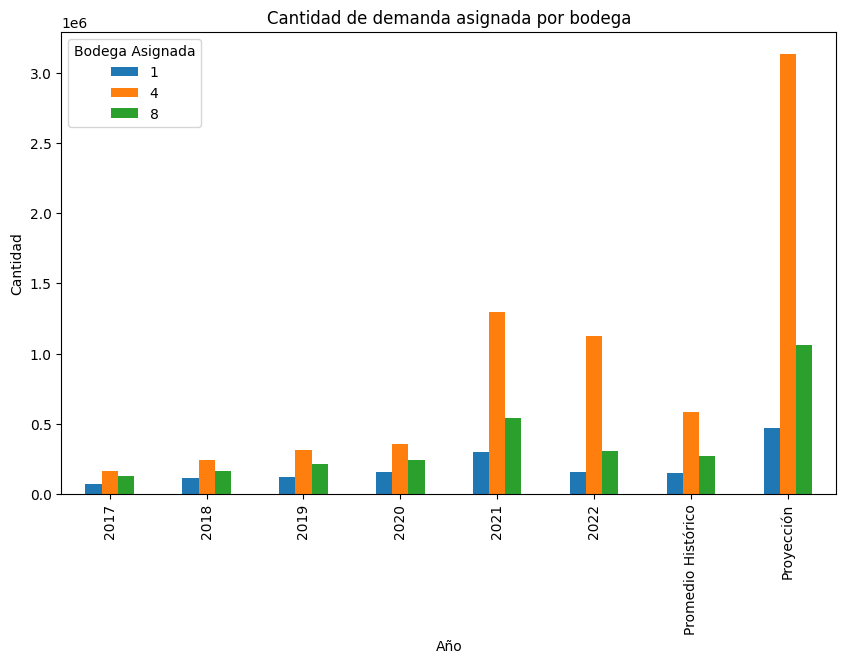

In [57]:
# Gráfica de resultados
combined_df = pd.concat([resultado_1, resultado_1b, resultado_2])

pivot_df = combined_df.pivot(index='Año', columns='Bodega Asignada', values='Cantidad')
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cantidad de demanda asignada por bodega')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.legend(title='Bodega Asignada')
plt.show()


In [63]:
#Código construído ocupando ChatGPT

# Regresión lineal de la demanda histórica por bodega para el año 2032, para determinar proyección aproximada por esta regresión

from sklearn.linear_model import LinearRegression

# Crear un DataFrame con los datos

df = resultado_1

# Obtener las bodegas únicas
bodegas = df['Bodega Asignada'].unique()

# Crear un modelo de regresión lineal por bodega
proyecciones = []

for bodega in bodegas:
    df_bodega = df[df['Bodega Asignada'] == bodega]
    model = LinearRegression()
    X = df_bodega[['Año']]
    y = df_bodega['Cantidad']
    model.fit(X, y)
    
    # Predecir la cantidad para el año 2032
    year_2032 = 2032
    predicted_value = model.predict([[year_2032]])
    
    proyecciones.append({'Bodega Asignada': bodega, 'Proyeccion_2032': predicted_value[0]})

# Crear un DataFrame con las proyecciones
df_proyecciones = pd.DataFrame(proyecciones)

print(df_proyecciones)



   Bodega Asignada  Proyeccion_2032
0                1     5.148529e+05
1                4     3.432818e+06
2                8     1.001121e+06


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [68]:
# Calculo de diferencia porcentual entre ambos resultados (proyección entregada y proyección aproximada por regresión)

proyeccion_entregada = [467686, 3136619, 1058310]
proyeccion_calculada_rlm = [514852, 3432828, 1001121]

diferencia_porcentual = []
for i in range(len(proyeccion_entregada)):
    diferencia_porcentual.append(100*(proyeccion_calculada_rlm[i] - proyeccion_entregada[i]) / proyeccion_entregada[i])

print(diferencia_porcentual)

suma = 0
for i in proyeccion_entregada:
    suma += i

suma_2 = 0
for i in proyeccion_calculada_rlm:
    suma_2 += i

print(suma, suma_2)

[10.084971540734596, 9.443576028838695, -5.403804178359838]
4662615 4948801


## 2. Análisis de tamaño de bodegas óptimas

### 2.1 Caso histórico

In [3]:
# Bases de datos

# Ventas categorizadas y asignación resultante
bdd_ventas = pd.read_excel("BDD_Bodegas_Categorizada.xlsx")
bdd_asignaciones = pd.read_excel("Resultados/Primera Categorizacion/tiempos_p_3_Manhattan.xlsx")
bdd_ventas['Fecha'] = pd.to_datetime(bdd_ventas['Fecha'])
bdd_ventas['Semana'] = bdd_ventas['Fecha'].dt.strftime('%U')
bdd_ventas['Año'] = bdd_ventas['Fecha'].dt.year
bdd_ventas['Año-Sem'] = bdd_ventas['Año'].astype(str) + "-" + bdd_ventas['Semana'].astype(str)

#Comunas
bdd_comunas = pd.read_excel("BDD_Bodegas.xlsx", sheet_name=3)

In [4]:
# Agrupación de ventas por cliente 
bdd_ventas_agrupadas = bdd_ventas.groupby(['ID Cliente', 'Año-Sem']).agg({"Cantidad": "sum", "Comuna Despacho": "first", 'ID Bodega Despacho': 'first', 'Categoria': 'first'}).reset_index()
bdd_ventas_agrupadas = bdd_ventas_agrupadas.merge(bdd_comunas, left_on='Comuna Despacho', right_on='Comuna')
bdd_ventas_agrupadas['Cantidad'] = bdd_ventas_agrupadas['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)

# Juntamos asginaciones con demandas tanto de la bdd historica como de la proyeccion
bdd_historica = bdd_ventas_agrupadas.merge(bdd_asignaciones, left_on = "ID Cliente", right_on = "Unnamed: 0" )

# Resultados
resultado_1 = bdd_historica.groupby(['Bodega Asignada', 'Año-Sem'])['Cantidad'].sum().reset_index()

In [5]:
promedio_por_bodega = resultado_1.groupby('Bodega Asignada')['Cantidad'].mean()

In [6]:
promedio_por_bodega

Bodega Asignada
1     3029.725139
4    11681.610228
8     5331.575766
Name: Cantidad, dtype: float64

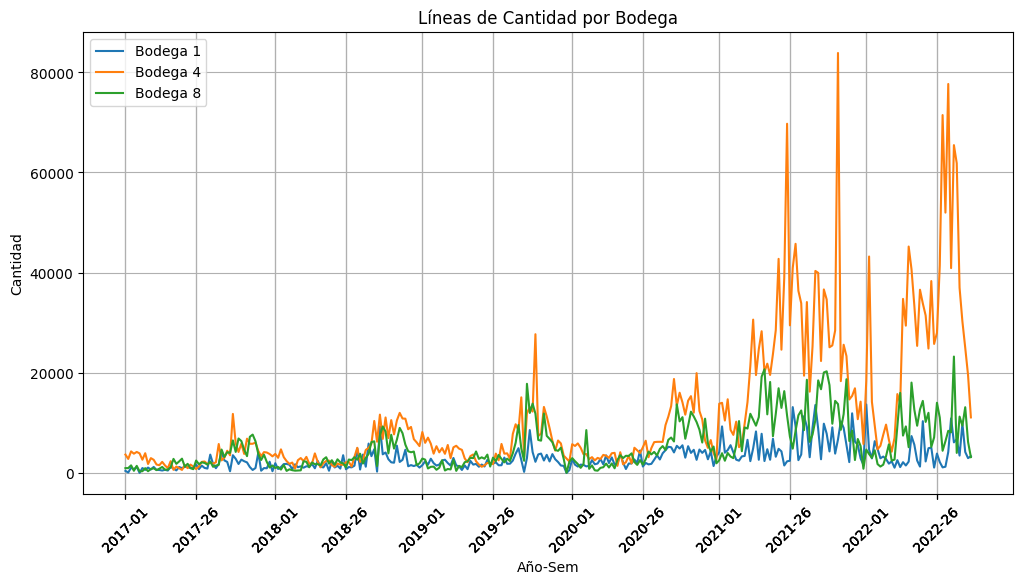

In [7]:
# Supongamos que tienes un DataFrame llamado 'df' con la estructura proporcionada
df = resultado_1

# Crear un gráfico con líneas separadas para cada bodega
plt.figure(figsize=(12, 6))
for bodega, data in df.groupby('Bodega Asignada'):
    plt.plot(data['Año-Sem'], data['Cantidad'], label=f'Bodega {bodega}')

plt.xlabel('Año-Sem')
plt.ylabel('Cantidad')
plt.title('Líneas de Cantidad por Bodega')
plt.legend()

# Especifica las fechas que deseas mostrar en el eje x
fechas_mostradas = ["2017-01", "2017-26", "2018-01", "2018-26", "2019-01", "2019-26", "2020-01", "2020-26", "2021-01", "2021-26", "2022-01", "2022-26"]

# Filtra el DataFrame para mostrar solo las fechas especificadas
df_mostrado = df[df['Año-Sem'].isin(fechas_mostradas)]

# Establece las marcas (ticks) en el eje x
plt.xticks(df_mostrado['Año-Sem'], rotation=45)

plt.grid(True)
plt.show()


### 2.2 Caso Proyecciones

In [8]:
# Proyecciones categorizadas y asignación resultante
bdd_proyecciones = pd.read_excel("BDD_Bodegas_Categorizada_proy.xlsx")
bdd_asignaciones_proy = pd.read_excel("Resultados/Proyeccion pmedian/tiempos_p_3_Manhattan.xlsx")

# Año y semana de las proyecciones
bdd_proyecciones['Año'] = bdd_proyecciones['Fecha'].dt.year
bdd_proyecciones['Semana'] = bdd_proyecciones['Fecha'].dt.strftime('%U')
bdd_proyecciones['Año-Sem'] = bdd_proyecciones['Año'].astype(str) + "-" + bdd_proyecciones['Semana'].astype(str)

In [9]:
# Agrupación de proyecciones por cliente
bdd_proyecciones_agrupadas = bdd_proyecciones.groupby(["ID Cliente",'Año-Sem'] ).agg({"Cantidad": "sum", "Comuna Despacho": "first", 'ID Bodega Despacho': 'first', 'Categoria': 'first'}).reset_index()
bdd_proyecciones_agrupadas = bdd_proyecciones_agrupadas.merge(bdd_comunas, left_on='Comuna Despacho', right_on='Comuna')
bdd_proyecciones_agrupadas['Cantidad'] = bdd_proyecciones_agrupadas['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)

# Juntamos asginaciones con demandas tanto de la bdd de la proyeccion
bdd_proyecciones = bdd_proyecciones_agrupadas.merge(bdd_asignaciones_proy, left_on = "ID Cliente", right_on = "Unnamed: 0" )

# Resultados
resultado_2 = bdd_proyecciones.groupby(['Bodega Asignada', 'Año-Sem'])['Cantidad'].sum().reset_index()

In [10]:
promedio_por_bodega = resultado_2.groupby('Bodega Asignada')['Cantidad'].mean()
promedio_por_bodega

Bodega Asignada
1     8660.864345
4    57927.900516
8    19598.333185
Name: Cantidad, dtype: float64

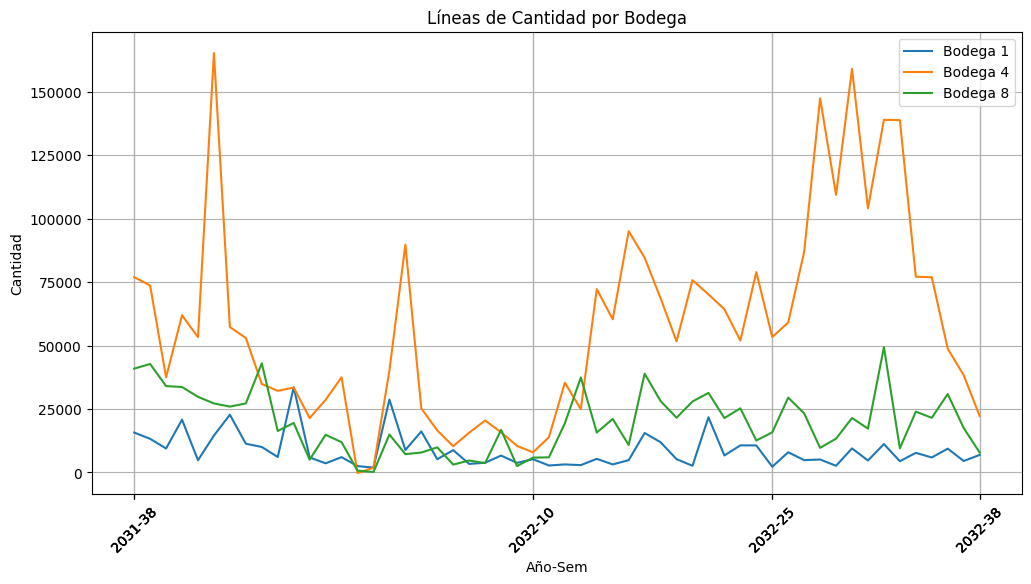

In [11]:
# Supongamos que tienes un DataFrame llamado 'df' con la estructura proporcionada
df = resultado_2

# Crear un gráfico con líneas separadas para cada bodega
plt.figure(figsize=(12, 6))
for bodega, data in df.groupby('Bodega Asignada'):
    plt.plot(data['Año-Sem'], data['Cantidad'], label=f'Bodega {bodega}')

plt.xlabel('Año-Sem')
plt.ylabel('Cantidad')
plt.title('Líneas de Cantidad por Bodega')
plt.legend()

# Especifica las fechas que deseas mostrar en el eje x
fechas_mostradas = ["2031-38", "2032-10", "2032-25", "2032-38"]

# Filtra el DataFrame para mostrar solo las fechas especificadas
df_mostrado = df[df['Año-Sem'].isin(fechas_mostradas)]

# Establece las marcas (ticks) en el eje x
plt.xticks(df_mostrado['Año-Sem'], rotation=45)

plt.grid(True)
plt.show()


## 3. Medidas de desempeño

### 3.1 Lotes históricos 

In [50]:
delta_1 = 1
delta_4 = 1
delta_8 = 1
tamaño_bodegas_historica = {1: 3029.72513*delta_1, 4: 11681.610228*delta_4, 8: 5331.575766*delta_8}

In [51]:
# Porcentaje de lote/cantidad en bodega
prom_ocup = list()
for bodega in [1,4,8]:
    bdd = resultado_1[resultado_1["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_historica[bodega]:
            suma += 1
        else:
            suma += bdd.iloc[i,2]/tamaño_bodegas_historica[bodega]

    # Calculamos el promedio de ocupación de la bodega
    promedio = suma/len(bdd)
    prom_ocup.append(promedio)

prom_ocup

[0.7001941004309306, 0.573686949383651, 0.6478563686895387]

In [52]:
# Cantidad de semanas que me pase de tamaño
cantidad_sem_pasadas = list()

for bodega in [1,4,8]:
    bdd = resultado_1[resultado_1["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_historica[bodega]:
            suma += 1

    cantidad_sem_pasadas.append(f"Semanas totales: {len(bdd)}, Semanas pasadas: {suma}, Porcentaje: {suma/len(bdd)}")

cantidad_sem_pasadas


['Semanas totales: 300, Semanas pasadas: 103, Porcentaje: 0.3433333333333333',
 'Semanas totales: 299, Semanas pasadas: 90, Porcentaje: 0.3010033444816054',
 'Semanas totales: 300, Semanas pasadas: 110, Porcentaje: 0.36666666666666664']

In [53]:
# Promedio de cuanto me pase de tamaño de bodega
promedio_pasada = list()

for bodega in [1,4,8]:
    bdd = resultado_1[resultado_1["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    cantidad_pasadas = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_historica[bodega]:
            suma += bdd.iloc[i,2]/tamaño_bodegas_historica[bodega] - 1
            cantidad_pasadas += 1

    promedio_pasada.append(suma/cantidad_pasadas)

promedio_pasada

[0.8732210753838002, 1.41630669041281, 0.9603917218466606]

In [54]:
# Cantidad de demanda no satisfecha
demanda_no_satisfecha = list()

for bodega in [1,4,8]:
    bdd = resultado_1[resultado_1["Bodega Asignada"]==bodega] 

    suma = 0
    suma_2 = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_historica[bodega]:
            suma += bdd.iloc[i,2] - tamaño_bodegas_historica[bodega]
        suma_2 += bdd.iloc[i,2]
        

    demanda_no_satisfecha.append(f"No satisfecha: {suma}, Total: {suma_2}, Porcentaje: {suma/suma_2}")

demanda_no_satisfecha

['No satisfecha: 272498.843122, Total: 908917.5417079997, Porcentaje: 0.2998059016552058',
 'No satisfecha: 1489026.844864, Total: 3492801.4582054648, Porcentaje: 0.42631305062184494',
 'No satisfecha: 563244.1353071133, Total: 1599472.729853285, Porcentaje: 0.35214363133204407']

### 3.2 Lotes proyección

In [45]:
tamaño_bodegas_proyecciones = {1: 8660.864345, 4: 57927.900516, 8: 19598.333185}

In [46]:
# Porcentaje de lote/cantidad en bodega
prom_ocup = list()
for bodega in [1,4,8]:
    bdd = resultado_2[resultado_2["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_proyecciones[bodega]:
            suma += 1
        else:
            suma += bdd.iloc[i,2]/tamaño_bodegas_proyecciones[bodega]

    # Calculamos el promedio de ocupación de la bodega
    promedio = suma/len(bdd)
    prom_ocup.append(promedio)

prom_ocup

[0.7160781445015042, 0.7301914113482719, 0.7471235371903897]

In [47]:
# Cantidad de semanas que me pase de tamaño
cantidad_sem_pasadas = list()

for bodega in [1,4,8]:
    bdd = resultado_2[resultado_2["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_proyecciones[bodega]:
            suma += 1

    cantidad_sem_pasadas.append(f"Semanas totales: {len(bdd)}, Semanas pasadas: {suma}, Porcentaje: {suma/len(bdd)}")

cantidad_sem_pasadas


['Semanas totales: 54, Semanas pasadas: 21, Porcentaje: 0.3888888888888889',
 'Semanas totales: 54, Semanas pasadas: 24, Porcentaje: 0.4444444444444444',
 'Semanas totales: 54, Semanas pasadas: 25, Porcentaje: 0.46296296296296297']

In [48]:
# Promedio de cuanto me pase de tamaño de bodega
promedio_pasada = list()

for bodega in [1,4,8]:
    bdd = resultado_2[resultado_2["Bodega Asignada"]==bodega] 

    # Por semana, calculamos el porcentaje de lote/cantidad en bodega y los sumamos
    suma = 0
    cantidad_pasadas = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_proyecciones[bodega]:
            suma += bdd.iloc[i,2]/tamaño_bodegas_proyecciones[bodega] - 1
            cantidad_pasadas += 1

    promedio_pasada.append(suma/cantidad_pasadas)

promedio_pasada

[0.7300847714185175, 0.6070693244654523, 0.546213159654168]

In [49]:
# Cantidad de demanda no satisfecha
demanda_no_satisfecha = list()

for bodega in [1,4,8]:
    bdd = resultado_2[resultado_2["Bodega Asignada"]==bodega] 

    suma = 0
    suma_2 = 0
    for i in range(len(bdd)):
        if bdd.iloc[i,2] > tamaño_bodegas_proyecciones[bodega]:
            suma += bdd.iloc[i,2] - tamaño_bodegas_proyecciones[bodega]
        suma_2 += bdd.iloc[i,2]
        

    demanda_no_satisfecha.append(f"No satisfecha: {suma}, Total: {suma_2}, Porcentaje: {suma/suma_2}")

demanda_no_satisfecha

['No satisfecha: 132786.46847772837, Total: 467686.6746548577, Porcentaje: 0.28392185553655513',
 'No satisfecha: 843990.034414801, Total: 3128106.6278626993, Porcentaje: 0.2698085886514243',
 'No satisfecha: 267621.68732334964, Total: 1058309.9919828512, Porcentaje: 0.2528764628045638']

## 4. Demandas para simulación

### 4.1 Demandas históricas

Notamos que entre los años 2017 existe cierta estacionalidad y, entre los años 2021 y 2022, otra. Por esto, separamos los casos y observamos

In [12]:
resultado_1["Semana"] = resultado_1["Año-Sem"].str.split("-").str[1]
resultado_1["Año"] = resultado_1["Año-Sem"].str.split("-").str[0]

C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\1120270074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\1120270074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\1120270074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

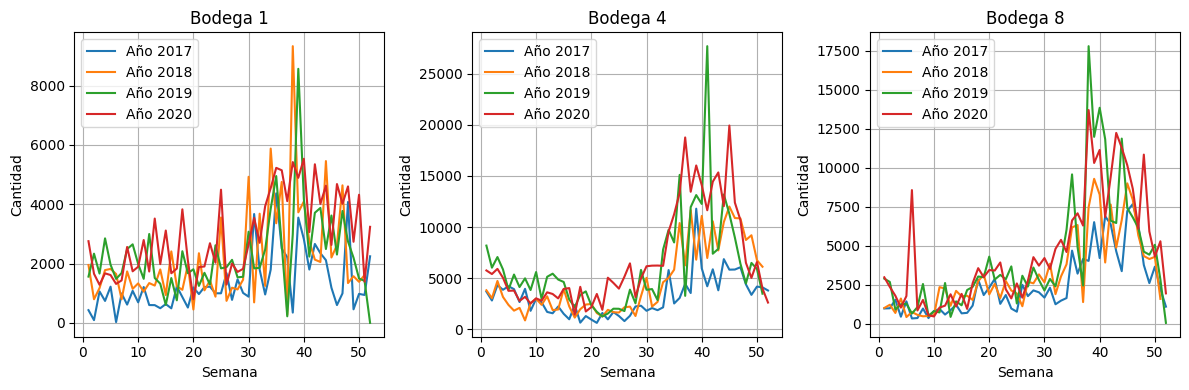

In [20]:
bodegas = {1: resultado_1[resultado_1["Bodega Asignada"]==1], 4: resultado_1[resultado_1["Bodega Asignada"]==4], 8: resultado_1[resultado_1["Bodega Asignada"]==8]}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 fila y 3 columnas para los tres gráficos

for i, bodega in enumerate([1, 4, 8]):
    for año in ["2017", "2018", "2019", "2020"]:
        data = bodegas[bodega][bodegas[bodega]["Año"] == año]
        data["Semana"] = data["Semana"].astype(int)
        data = data[data["Semana"] > 0]
        #data = data[data["Semana"] < 14]
        axs[i].plot(data['Semana'], data['Cantidad'], label=f'Año {año}')

    axs[i].set_xlabel('Semana')
    axs[i].set_ylabel('Cantidad')
    axs[i].set_title(f'Bodega {bodega}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()  
plt.show()



C:\Users\Diego\AppData\Local\Temp\ipykernel_32640\3208542531.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_32640\3208542531.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_32640\3208542531.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

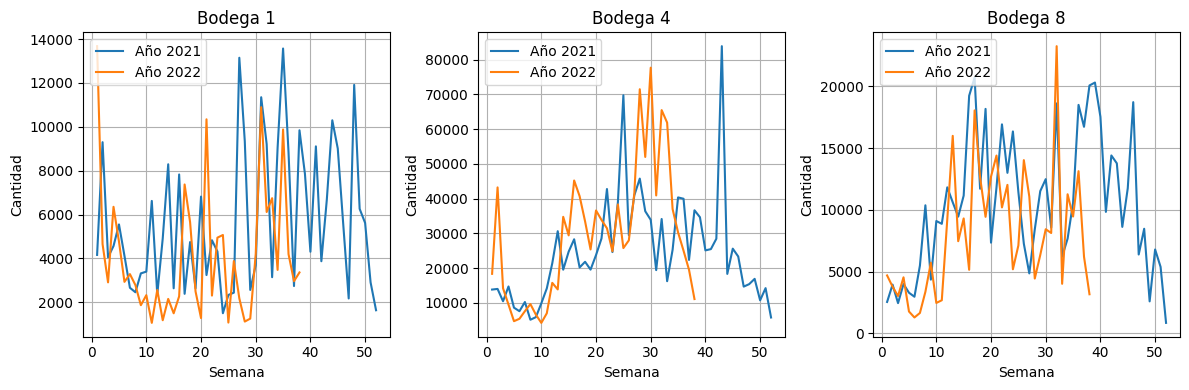

In [98]:
bodegas = {1: resultado_1[resultado_1["Bodega Asignada"]==1], 4: resultado_1[resultado_1["Bodega Asignada"]==4], 8: resultado_1[resultado_1["Bodega Asignada"]==8]}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 fila y 3 columnas para los tres gráficos

for i, bodega in enumerate([1, 4, 8]):
    for año in ["2021", "2022"]:
        data = bodegas[bodega][bodegas[bodega]["Año"] == año]
        data["Semana"] = data["Semana"].astype(int)
        data = data[data["Semana"] > 0]
        axs[i].plot(data['Semana'], data['Cantidad'], label=f'Año {año}')

    axs[i].set_xlabel('Semana')
    axs[i].set_ylabel('Cantidad')
    axs[i].set_title(f'Bodega {bodega}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()  # Ajustar el diseño de los gráficos dentro del marco
plt.show()

Para determinar la distribución, ocupamos un código obtenido a través de Chat GPT de Open IA. Seleccionamos la bodega y estacionalidad para poder observar la distribución que mejor se ajusta.

A priori, observamos que el comportamiento de la demanda histórica difiere para el período entre 2017-2020 y el 2021-2022. Por esto, separamos el análisis de las distribuciones

In [17]:
b = 1
data = resultado_1

#Acotamos desde 2017 a 2020
data = data[data["Año"] >= "2017"]
data = data[data["Año"] <= "2020"]

data = data[data["Bodega Asignada"] == b]
data["Semana"] = data["Semana"].astype(int)
data = data[data["Semana"] > 0]
data = data[data["Semana"] < 14]

# Ordeno por cantidad la base de datos
data = data.sort_values(by=['Cantidad'], ascending=True)

        

La mejor distribución es weibull_min con parámetros (1.3137531395682527, 651.0240112030416, 13776.25356683342)


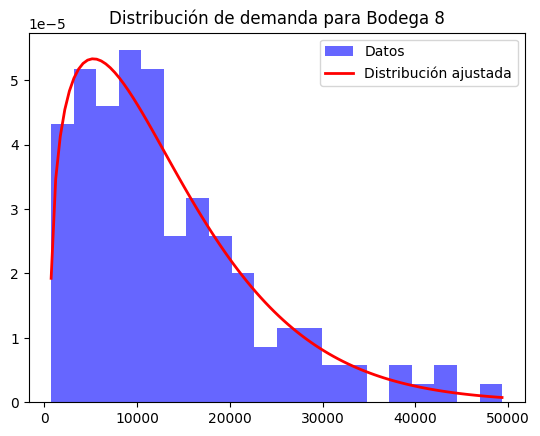

In [60]:
demanda = data['Cantidad']

# Lista de distribuciones a ajustar
distribuciones = [stats.norm, stats.expon, stats.geom, stats.t, stats.lognorm,  stats.chi2,  stats.weibull_min] #beta, gamma, f es la mejor con datos de 2017 a 2022

# Inicializamos valores
mejor_distribucion = None
mejor_params = ()
mejor_kstest = float('inf')

# Iteramos para las distintas distribuciones
for distribucion in distribuciones:
    if distribucion == stats.geom:

        # Estimación para la distribución geométrica (funciona distinto a las demás)
        p_geom = 1 - np.mean(demanda)
        params = (p_geom,)
    else:
        # Estimación de los parámetros 
        params = distribucion.fit(demanda)
    
    ks_statistic, ks_p_value = stats.kstest(demanda, distribucion.name, params)
    
    # Compara el estadístico KS con el mejor encontrado hasta ahora
    if ks_statistic < mejor_kstest:
        mejor_distribucion = distribucion
        mejor_params = params
        mejor_kstest = ks_statistic

# Distribución
print(f"La mejor distribución es {mejor_distribucion.name} con parámetros {mejor_params}")

# Gráfica de histograma 
plt.hist(demanda, bins=20, density=True, alpha=0.6, color='b', label='Datos')
x = np.linspace(min(demanda), max(demanda), 100)
pdf = mejor_distribucion.pdf(x, *mejor_params)
plt.plot(x, pdf, 'r-', lw=2, label='Distribución ajustada')
plt.legend()
plt.title(f'Distribución de demanda para Bodega {b}')
plt.show()


### 4.2 Demandas proyectadas + Demandas 2021 y 2022

In [ ]:
resultado_2["Semana"] = resultado_2["Año-Sem"].str.split("-").str[1]
resultado_2["Año"] = resultado_2["Año-Sem"].str.split("-").str[0]

In [59]:
#Juntamos las bases de datos de resultado_1 y resultado_2
resultado_3 = pd.concat([resultado_1, resultado_2])

In [29]:
resultado_3["Semana"] = resultado_3["Año-Sem"].str.split("-").str[1]
resultado_3["Año"] = resultado_3["Año-Sem"].str.split("-").str[0]
bodegas = {1: resultado_3[resultado_3["Bodega Asignada"]==1], 4: resultado_3[resultado_3["Bodega Asignada"]==4], 8: resultado_3[resultado_3["Bodega Asignada"]==8]}

C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\3921756505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\3921756505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Semana"] = data["Semana"].astype(int)
C:\Users\Diego\AppData\Local\Temp\ipykernel_1928\3921756505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

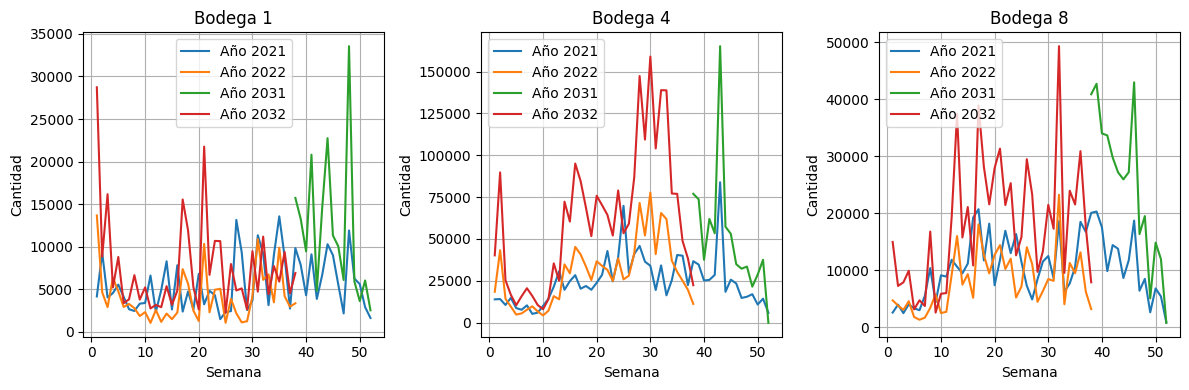

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 fila y 3 columnas para los tres gráficos

for i, bodega in enumerate([1, 4, 8]):
    for año in ["2021","2022","2031","2032"]:
        data = bodegas[bodega][bodegas[bodega]["Año"] == año]
        data["Semana"] = data["Semana"].astype(int)
        data = data[data["Semana"] > 0]
        #data = data[data["Semana"] < 14]
        axs[i].plot(data['Semana'], data['Cantidad'], label=f'Año {año}')

    axs[i].set_xlabel('Semana')
    axs[i].set_ylabel('Cantidad')
    axs[i].set_title(f'Bodega {bodega}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()  
plt.show()


Verificamos qué distribución se ajusta mejor

La mejor distribución es weibull_min con parámetros (0.9290749044973574, 1868.3999999999999, 4352.515195637032)


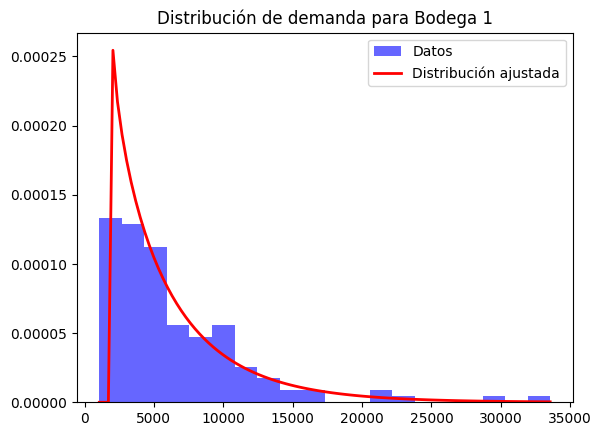

La mejor distribución es weibull_min con parámetros (1.1088805581349113, 4693.608092866201, 35500.10072913081)


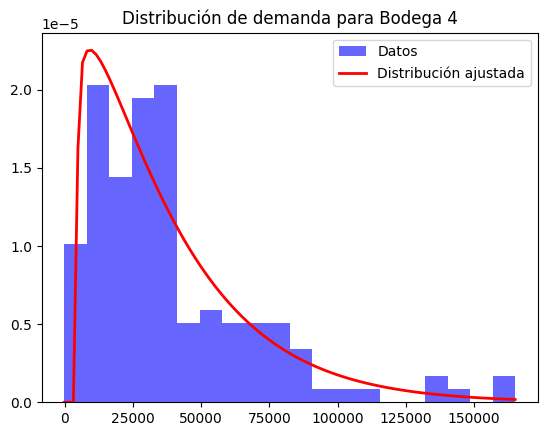

La mejor distribución es weibull_min con parámetros (1.3137531395682527, 651.0240112030416, 13776.25356683342)


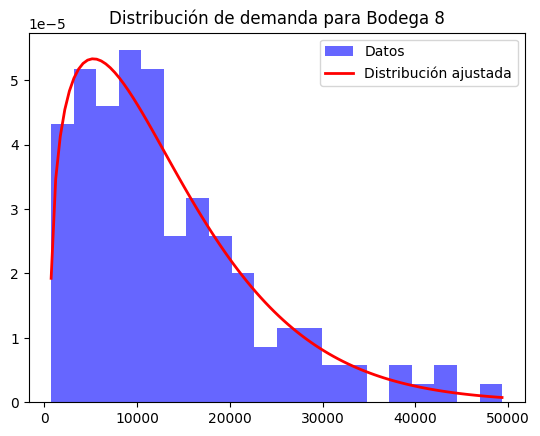

In [61]:
for b in [1,4,8]:
    
    data = resultado_3

    #Acotamos desde 2021 a 2032
    data = data[data["Año"] >= "2021"]

    data = data[data["Bodega Asignada"] == b]
    data["Semana"] = data["Semana"].astype(int)
    data = data[data["Semana"] > 0]
    #data = data[data["Semana"] < 14]

    # Ordeno por cantidad la base de datos
    data = data.sort_values(by=['Cantidad'], ascending=True)
    demanda = data['Cantidad']

    # Lista de distribuciones a ajustar
    distribuciones = [stats.norm, stats.expon, stats.geom, stats.t, stats.lognorm,  stats.chi2,  stats.weibull_min] #beta, gamma, f es la mejor con datos de 2017 a 2022

    # Inicializamos valores
    mejor_distribucion = None
    mejor_params = ()
    mejor_kstest = float('inf')

    # Iteramos para las distintas distribuciones
    for distribucion in distribuciones:
        if distribucion == stats.geom:

            # Estimación para la distribución geométrica (funciona distinto a las demás)
            p_geom = 1 - np.mean(demanda)
            params = (p_geom,)
        else:
            # Estimación de los parámetros 
            params = distribucion.fit(demanda)
        
        ks_statistic, ks_p_value = stats.kstest(demanda, distribucion.name, params)
        
        # Compara el estadístico KS con el mejor encontrado hasta ahora
        if ks_statistic < mejor_kstest:
            mejor_distribucion = distribucion
            mejor_params = params
            mejor_kstest = ks_statistic

    # Distribución
    print(f"La mejor distribución es {mejor_distribucion.name} con parámetros {mejor_params}")

    # Gráfica de histograma 
    plt.hist(demanda, bins=20, density=True, alpha=0.6, color='b', label='Datos')
    x = np.linspace(min(demanda), max(demanda), 100)
    pdf = mejor_distribucion.pdf(x, *mejor_params)
    plt.plot(x, pdf, 'r-', lw=2, label='Distribución ajustada')
    plt.legend()
    plt.title(f'Distribución de demanda para Bodega {b}')
    plt.show()

